# Análisis y Generación de Diccionarios Semánticos para la Criptoanálisis de Contraseñas WPA2 en Lengua Española

## Proyecto | Introducción a la Criptografía


* Paula Daniela Guzmán Zabala
* Daniel Felipe Montenegro Herrera
* Tomás Sebastián Vallejo Fonseca

22 de Julio de 2025 - Bogotá

Introducción a la Criptografía y Seguridad

Universidad Nacional de Colombia

---

El objetivo principal de este proyecto es explorar y desarrollar un método alternativo al enfoque tradicional de ataque por fuerza bruta para romper claves de WPA2 mediante el uso de contraseñas semánticas en el contexto del lenguaje español. Tradicionalmente, las contraseñas de redes Wi-Fi, como las de WPA2, son seleccionadas de manera que pueden ser fáciles de recordar para los usuarios pero, en muchos casos, son relativamente débiles cuando se consideran a través de un enfoque semántico. Estas contraseñas generalmente no son largas y combinan palabras comunes, números y caracteres especiales.

En lugar de realizar ataques por fuerza bruta a través de todas las combinaciones posibles (que puede llevar años debido a la vastedad de combinaciones de caracteres), nuestro enfoque se centra en un ataque semántico que emplea el conocimiento del lenguaje y las frecuencias estadísticas de las palabras para generar diccionarios de contraseñas más efectivas y eficientes.

---

## Adquisición y Preparación de Datos

En esta primera fase, se obtiene el corpus de datos sin procesar. Se automatiza la descarga del fichero corpes_lemas.zip desde la Real Academia Española (RAE), que contiene una lista de lemas del español junto con sus frecuencias. Inmediatamente después, se descomprime el archivo y se elimina el fichero ZIP para mantener limpio el directorio de trabajo. Este es el punto de partida para construir nuestro diccionario semántico.

In [ ]:
# Automatización de la descarga del corpes

!curl -L -A "Mozilla/5.0" -o corpes_lemas.zip https://www.rae.es/corpes/assets/rae/files/corpes/corpes_lemas.zip

**NOTA**: En caso de que el archivo .zip con los lemas no se descarge correctamente, lo invitamos a darle click al siguiente link y poner el .zip que se descarga automáticamente dentro de la ruta principal de este proyecto /semanticdictgen-wpa2-es.

[https://www.rae.es/corpes/assets/rae/files/corpes/corpes_lemas.zip](https://www.rae.es/corpes/assets/rae/files/corpes/corpes_lemas.zip)

In [ ]:
import zipfile, os

# Se extrae el zipfile que contiene los lemas del CORPES XXI

with zipfile.ZipFile("corpes_lemas.zip", "r") as zip_ref:
    zip_ref.extractall()

os.remove("corpes_lemas.zip")

### Parseo y Limpieza Inicial del Corpus

Una vez obtenidos los datos, es necesario procesarlos. En esta sección, se lee el archivo de texto del corpus y se utiliza una expresión regular para parsear cada línea, extrayendo el lema y sus tres tipos de frecuencia. Estos datos se cargan en un DataFrame de Pandas para facilitar su manipulación. Como paso de limpieza crucial, se eliminan todos los lemas cuya frecuencia normalizada es menor a 1, lo que significa que solo conservamos palabras que aparecen al menos una vez por cada millón de palabras, filtrando así términos extremadamente raros que son improbables candidatos para una contraseña.

In [ ]:
pip install pandas matplotlib unidecode jupyter langchain-ollama langchain-chroma langchain-U

In [5]:
import pandas, re

csv_output = "corpes_lemas_clean.csv"
dataset = "frecuencia_lemas_corpes_1_3.txt"

with open(dataset, "r", encoding="utf-8") as f:
    lines = f.readlines()

clean_rows = []

# Expresión regular para extraer los campos ignorando etiquetas como T, P, etc.
for line in lines:
    match = re.match(r'^(.+?)\s+[A-Z]\s+([\d.,]+)\s+([\d.,]+)\s+([\d.,]+)', line)
    if match:
        element = match.group(1).strip()
        freq_signs = float(match.group(2).replace(",", "").replace(".", ""))
        freq_sin_signs = float(match.group(3).replace(",", ""))
        freq_normal = float(match.group(4).replace(",", ""))
        clean_rows.append([element, freq_signs, freq_sin_signs, freq_normal])

corpes_df = pandas.DataFrame(clean_rows, columns=[
    "element",
    "frequency_signs",       # Frecuencia con signos ortográficos
    "frequency_no_signs",    # Frecuencia sin signos ortográficos
    "frequency"              # Frecuencia normal
])

corpes_df

,element,frequency_signs,frequency_no_signs,frequency
0,el,49657748.0,98648.64,113671.32
1,de,31062445.0,61707.75,71104.90
2,",",27823866.0,55274.08,63691.48
3,.,18660077.0,37069.56,42714.69
4,y,12468265.0,24769.09,28541.04
...,...,...,...,...
2004486,dos mil veintinueve,1.0,0.00,0.00
2004487,siete mil doscientos noventa y un,1.0,0.00,0.00
2004488,Sevilla Granada,1.0,0.00,0.00
2004489,Raúl Tejón Fernando Gil,1.0,0.00,0.00


In [6]:
# Eliminar filas donde la frecuencia normal es menor o igual a 1
# Es decir, filas que no tienen relevancia estadística al aparecer una vez o menos cada millón de palabras

corpes_df = corpes_df[corpes_df["frequency"] >= 1]

# Guardar CSV limpio
corpes_df.to_csv(csv_output, index=False)

corpes_df

,element,frequency_signs,frequency_no_signs,frequency
0,el,49657748.0,98648.64,113671.32
1,de,31062445.0,61707.75,71104.90
2,",",27823866.0,55274.08,63691.48
3,.,18660077.0,37069.56,42714.69
4,y,12468265.0,24769.09,28541.04
...,...,...,...,...
24723,Pablo Picasso,437.0,0.86,1.00
24724,UF,437.0,0.86,1.00
24725,pirotecnia,437.0,0.86,1.00
24726,VÍCTOR,437.0,0.86,1.00


## Normalización y Transliteración Semántica

Este es un paso fundamental del proyecto. Se define una función de transliteración con tres objetivos:

*  **Compatibilidad con WPA2**: Elimina cualquier carácter que no sea ASCII imprimible (\x20-\x7E).

* **Normalización Fonética**: Convierte caracteres con acentos o diacríticos a su equivalente base (e.g., "garcía" a "garcia") usando unidecode.

* **Expansión Semántica**: Para cada lema, genera dos versiones: una con espacios (si los tiene) y otra sin ellos (e.g., "Papa Francisco" y "PapaFrancisco"). Esto permite que diferentes formas de escribir una misma idea "choquen" o colisionen más adelante, fortaleciendo el enfoque semántico.

Esta función básicamente solo deja los caracteres imprimibles (los permitidos por WPA2) y reemplaza de forma "inteligente" acentos y otras cosas que tienen la misma fonetica o significado, haciendo que choquen los términos y a su vez lograr uso de los espacios de forma semántica. 

Por ejemplo:

**"Papá Francisco"** y **"Papa Francisco"**, se unen en dos filas iguales que tendrán la misma frecuencia y significado.

In [7]:
import unidecode

def transliterate(string):
    if 0 < len(string) < 64:
        string = re.sub(r"[^\x20-\x7E]", "", unidecode.unidecode(string.title()))
        return {string, string.replace(chr(32), "")}
    return {}

transliterate("gabriel garcía márquez")

{'Gabriel Garcia Marquez', 'GabrielGarciaMarquez'}

Aquí se aplica la función de transliteración a todo el corpus. Al generar múltiples versiones de un mismo lema (con y sin espacios), el número de filas en nuestro DataFrame aumenta. El paso siguiente es clave: se agrupan los lemas transliterados idénticos y se suman sus frecuencias. De esta forma, las "colisiones semánticas" (como "Papa" y "Papá", que ahora son "Papa") se consolidan en una única entrada con una frecuencia combinada, lo que nos da una medida más precisa de la relevancia de un término.

Es importante observar y destacar cómo cambió el número de nuestras filas con respecto al corpes orginal y esta nueva versión.

In [8]:
transliterated_data = []
for row in corpes_df.itertuples(index=False):
    transliterations = transliterate(row.element)
    for transliteration in transliterations:
        if transliteration:
            transliterated_data.append([transliteration, row.frequency])
corpes_df_tr = pandas.DataFrame(transliterated_data, columns=["transliterated", "frequency"])
corpes_df_tr

,transliterated,frequency
0,El,113671.32
1,De,71104.90
2,",",63691.48
3,.,42714.69
4,Y,28541.04
...,...,...
25577,Uf,1.00
25578,Pirotecnia,1.00
25579,Victor,1.00
25580,JoseMujica,1.00


Se agrupa para generar las colisiones de los términos y así sumar la frecuencia, para que queden juntos representados en una misma fila; también se organiza de mayor a menor frecuencia para mejor visualización.

In [9]:
transliterations = corpes_df_tr.groupby("transliterated")["frequency"].sum().sort_values(ascending=False)
transliterations

transliterated
El            116682.89
De             71150.19
,              63691.48
.              42714.69
Que            32166.81
                ...    
Traqueteo          1.00
Enquistar          1.00
Las Ventas         1.00
LasVentas          1.00
Hipertexto         1.00
Name: frequency, Length: 23472, dtype: float64

## Análisis Estadístico y Filtrado por Longitud

Para que nuestro diccionario sea eficiente, debemos enfocarnos en las longitudes de palabra más probables para una contraseña. En esta sección, se realiza un análisis estadístico de la longitud de los lemas transliterados, calculando la media y la desviación estándar y se visualiza esta distribución en un histograma. Usando estos datos, se establece un rango de longitud óptimo (de 1 a 14 caracteres en este caso) para descartar lemas demasiado cortos o largos, que son menos comunes en contraseñas reales.

In [10]:
transliteration_length = pandas.Series(transliterations.index.str.len())
mean_length = transliteration_length.mean() # Media de las longitudes de los lemas transliterados
std_length = transliteration_length.std() # Desviación estándar de las longitudes de los lemas transliterados
mean_length, std_length

(np.float64(8.062840831629176), np.float64(2.936624193469857))

Graficamos en un histograma la información de las longitudes y representamos la media, como también la desviación estandar para visualizar la frecuencia de los lemas de acuerdo a su longitud, y permitirnos tomar decisiones más adelante sobre cuáles longitudes tendremos en cuenta y cuales no.

Como criterio de decisión se usará la **desviación estandar**.

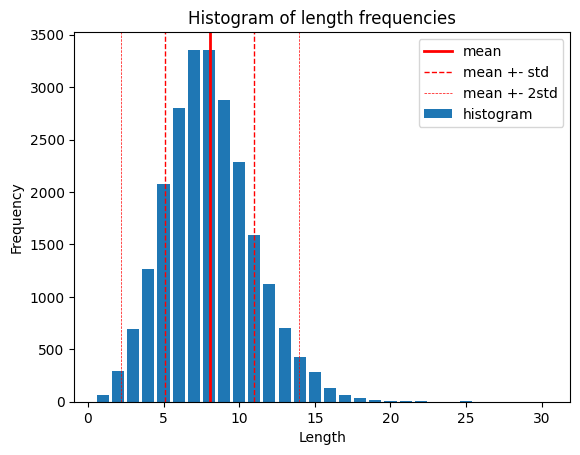

In [11]:
import matplotlib.pyplot

histogram = transliteration_length.value_counts().sort_index()
matplotlib.pyplot.bar(histogram.index, histogram, label="histogram")
matplotlib.pyplot.axvline(x=mean_length-(std_length*2), color="red", linestyle="--", linewidth=0.5)
matplotlib.pyplot.axvline(x=mean_length-std_length, color="red", linestyle="--", linewidth=1)
matplotlib.pyplot.axvline(x=mean_length, color="red", linestyle="-", label="mean", linewidth=2)
matplotlib.pyplot.axvline(x=mean_length+std_length, color="red", linestyle="--", label="mean +- std",linewidth=1)
matplotlib.pyplot.axvline(x=mean_length+(std_length*2), color="red", linestyle="--", label="mean +- 2std",linewidth=0.5)
matplotlib.pyplot.title("Histogram of length frequencies")
matplotlib.pyplot.ylabel("Frequency")
matplotlib.pyplot.xlabel("Length")
matplotlib.pyplot.legend()
matplotlib.pyplot.show()

A continuación se necesita definir el rango de longitud mínima y máxima de la palabra que tendremos en cuenta para el desarrollo del ataque semántico. Básicamente es dos veces la distancia de la media con respecto a la mínima longitud de palabra (1), para asi lograr una simetría y descartar los lemas que no nos serán realmente de utilidad.

De esta forma, sólo se tendrán en cuenta los lemas con longitud menor o igual al tope máximo de longitud de palabra encontrado **max_length**.

In [12]:
min_length = 1
max_length = round((mean_length - min_length) * 2)
(min_length, max_length)

(1, 14)

In [13]:
# Filtrar transliteraciones por longitud máxima
transliterations = transliterations[transliterations.index.str.len() <= max_length]
transliterations

transliterated
El            116682.89
De             71150.19
,              63691.48
.              42714.69
Que            32166.81
                ...    
Traqueteo          1.00
Enquistar          1.00
Las Ventas         1.00
LasVentas          1.00
Hipertexto         1.00
Name: frequency, Length: 22910, dtype: float64

In [14]:
# Obtener la longitud de cada transliteración (se usará más adelante)
transliteration_length = transliterations.index.str.len()
transliteration_length

Index([ 2,  2,  1,  1,  3,  1,  2,  1,  2,  3,
       ...
        7,  8,  3, 10,  7,  9,  9, 10,  9, 10],
      dtype='int64', name='transliterated', length=22910)

Con transliteration_length podemos hacer un conteo del numero de lemas que tenemos por cada una de las longitudes

In [15]:
transliteration_length_counts = transliteration_length.value_counts().sort_index() # Conteo las longitudes de los lemas transliterados
transliteration_length_counts

transliterated
1       61
2      295
3      698
4     1268
5     2072
6     2805
7     3357
8     3350
9     2876
10    2284
11    1592
12    1120
13     702
14     430
Name: count, dtype: int64

Se normaliza la frecuencia para que sea más manipulable más adelante, es decir, la convertimos a un valor entre 0 a 1.

In [16]:
# Normalización de la frecuencia de longitudes
length_frequency_distribution = (transliteration_length_counts / transliteration_length_counts.sum()).sort_index()
length_frequency_distribution

transliterated
1     0.002663
2     0.012876
3     0.030467
4     0.055347
5     0.090441
6     0.122436
7     0.146530
8     0.146224
9     0.125535
10    0.099694
11    0.069489
12    0.048887
13    0.030642
14    0.018769
Name: count, dtype: float64

Se realiza una agrupación final de las frecuencias dada la suma de las frecuencias por longitud. Luego, se divide esa suma entre 1,000,000 (un millón) puesto que, dada la documentación anexa del CORPES, la columna de frecuencias significa cuántas veces aparece el lema por cada millón de palabras en español.

De hecho, este fue el criterio principal por el que se descartaron las frecuencias que eran menores a 1 más arriba en este notebook.

In [17]:
length_frequencies_sum = transliterations.groupby(transliteration_length).sum().sort_index() / 1000000
length_frequencies_sum

transliterated
1     0.199854
2     0.305189
3     0.117763
4     0.081409
5     0.107444
6     0.082127
7     0.075918
8     0.062121
9     0.043489
10    0.027906
11    0.018098
12    0.009176
13    0.005779
14    0.003559
Name: frequency, dtype: float64

Finalmente, se busca una representación más fidedigna de lo que queremos entender como longitud, puesto que debe tener en cuenta la cantidad de lemas con esa longitud y su frecuencia, todo junto en un mismo dato. Para ello, se cruzan los dos valores que generamos anteriormente, es decir **length_frequency_distribution** y **length_frequencies_sum**, con el objetivo de crear **weighted_frequency_sum**, el dato que sí va a tener en cuenta la cantidad de lemas junto con su frecuencia respecto a la longitud.

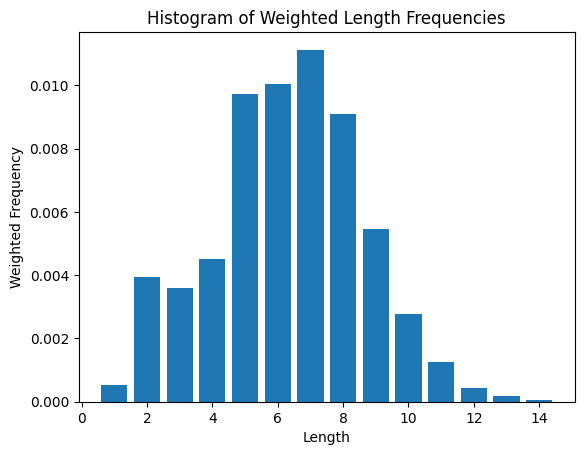

In [18]:
weighted_frequency_sum = length_frequency_distribution * length_frequencies_sum
matplotlib.pyplot.bar(weighted_frequency_sum.index, weighted_frequency_sum, label="histogram")
matplotlib.pyplot.title("Histogram of Weighted Length Frequencies")
matplotlib.pyplot.ylabel("Weighted Frequency")
matplotlib.pyplot.xlabel("Length")
matplotlib.pyplot.show()

## Generación de Permutaciones de Longitud Ponderadas

Las contraseñas a menudo son una concatenación de varias palabras. Esta sección modela esa realidad. Primero, se calcula una "frecuencia ponderada" para cada longitud de palabra, que considera tanto la cantidad de lemas de esa longitud como su frecuencia de uso. Luego, se generan todas las permutaciones posibles de longitudes de palabra (hasta un máximo de 3 niveles) que cumplen con los requisitos de longitud de una clave WPA2 (8-63 caracteres). Cada permutación (e.g., "palabra de 5 + palabra de 8") recibe un score, priorizando así las estructuras de contraseña más probables según nuestro análisis semántico.

Arbitrariamente decimos que formaremos solo contraseñas de 3 niveles, pero esta variable se puede cambiar y simplemente generar contraseñas de más o menos niveles.

**Nivel (LEVELS)**: Es la cantidad de lemas que concatenamos consecutivamente.

Ejemplo: CoronelAurelianoBuendia -> (se concatenó Coronel + Aureliano + Buendia)

In [19]:
LEVELS = 3

A continuación, se usa la media que calculada anteriormente (mean_length) y se le aplica la función techo, además, se multiplica por el número de niveles escogidos, esto con el fin de saber la longitud máxima de la contraseña que vamos a generar al permutar los lemas.

In [20]:
import math

max_permutation_sum = math.ceil(mean_length) * LEVELS
max_permutation_sum

27

La longitud de una contraseña WPA2 va desde 8 hasta 63 caracteres, sin embargo nuestra cota superior sera la calculada justo en el bloque anterior (**max_permutation_sum**), con ello entonces, se realizan los siguientes pasos:

1. Crear todas las permutaciones posibles.
2. Verificar que su suma no sea inferior a **8** o no supere **max_permutation_sum**.
3. Hallar una frecuencia especial a la que llamaremos la Frecuencia Ponderada de la Permutación.

In [21]:
import itertools

permutations_strs = []
permutation_frequencies = []

for level in range(1, LEVELS+1):
    permutations = itertools.product(range(min_length, max_length), repeat=level)
    for permutation in permutations:
        permutation_sum = sum(permutation)
        if 8 <= permutation_sum <= max_permutation_sum:
            # Frecuencia ponderada de la permutación (Frecuecia Especial)
            permutation_frequencies.append(sum(weighted_frequency_sum[num]*num/permutation_sum for num in permutation) * 1/len(permutation))
            permutations_strs.append(" ".join(str(num) for num in permutation))
weighted_permutations = pandas.Series(permutation_frequencies, index=permutations_strs).sort_values(ascending=False)
weighted_permutations

8          0.009084
7 7        0.005562
9          0.005459
7 6        0.005315
6 7        0.005315
             ...   
1 1 13     0.000075
1 13 1     0.000075
13 1 13    0.000063
1 13 13    0.000063
13 13 1    0.000063
Length: 1952, dtype: float64

## Configuración del Entorno de Búsqueda Semántica

Para poder encontrar lemas semánticamente relacionados (e.g., "Jesús" y "Judas"), utilizamos un modelo de embeddings y una base de datos vectorial. Aquí se configura el entorno de la siguiente manera:

1. Se descarga el modelo de embeddings nomic-embed-text a través de Ollama.

2. Se inicializa la base de datos vectorial ChromaDB, que almacenará los "vectores" (representaciones numéricas) de nuestros lemas.

3. Se resetea la colección para asegurar que no haya datos duplicados de ejecuciones anteriores.

4. Finalmente, se convierten todos nuestros lemas transliterados a vectores y se guardan en ChromaDB, dejándola lista para realizar búsquedas semánticas.

### Descarga del Modelo de Embeddings

Embedding Model: **Nomic**

A partir de estudios y pruebas anteriores respecto a diferentes modelos de incrustación, incluyendo DeepSeek-R1, LLama 3.2, y Phi 3.5, no fue hasta que se usó nomic-embed-text cuando se vieron resultados significativamente mejores. Este fue el criterio por el cual se decidió que se usaría este modelo de incrustació. Ahora, con ayuda de Ollama, instalaremos el modelo de incrustación de Nomic.

https://ollama.com/library/nomic-embed-text

Para instalar lo necesario para utilizar Ollama, por favor ejecute este comando en su terminal como administrador:

```bash
curl -fsSL https://ollama.com/install.sh | sh
```

In [22]:
!ollama pull nomic-embed-text

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling mani

Vamos a crear nuestro modelo para poder utilizarlo después en ChromaDB, nuestra base de datos vectorial.

In [23]:
from langchain_ollama import OllamaEmbeddings

nomic_ollama_embeddings = OllamaEmbeddings(model="nomic-embed-text")

#### Almacenamiento en la base de datos de vectores

ChromaDB es nuestra base de datos vectorial elegida. Con la ayuda de nuestro modelo de incrustación proporcionado por Nomic, almacenaremos todos los fragmentos generados a partir de los textos, para que posteriormente podamos consultarlos y hacerlos parte de nuestro contexto para cada consulta a los LLM.

##### Hacer persistente el chroma

Aquí tenemos que pensar un paso por delante en el tiempo, así que asumimos que chroma ya es persistente, lo que significa que existe en un directorio. Si no hacemos esto, lo que ocurrirá cada vez que ejecutemos este Notebook, añadiremos cadenas repetidas una y otra vez a la base de datos de vectores. Así que es una buena práctica resetear Chroma y en caso de que no exista, se creará y simplemente permanecerá vacía. [4]

In [24]:
from langchain_chroma import Chroma

def reset_collection(collection_name, persist_directory):
    # Se encarga de resetear la colección de Chroma para evitar duplicados
    Chroma(
        collection_name=collection_name,
        embedding_function=nomic_ollama_embeddings,
        persist_directory=persist_directory
    ).delete_collection()

reset_collection("corpes_embeddings", "chroma")

In [25]:
# Convertir transliteraciones a vectores y guardarlas en ChromaDB
Chroma.from_texts(texts=transliterations.index.to_list(), collection_name="corpes_embeddings", embedding=nomic_ollama_embeddings, persist_directory="chroma")

In [26]:
# Verificación de la persistencia de ChromaDB
vector_store = Chroma(collection_name="corpes_embeddings", embedding_function=nomic_ollama_embeddings, persist_directory="chroma")

len(vector_store.get()["ids"])

22910

> *Estamos accediendo a los datos persistentes, no a los datos en memoria.*


#### Utilizar un Vectorstore como Recuperador

Un recuperador es una interfaz especializada en recuperar información a partir de una consulta no estructurada. Se tiene en cuenta **search_kwargs={"k": 3}**, es decir solo arroja los 3 mejores resultados.

In [27]:
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

docs = retriever.invoke("Jesus")

for doc in docs:
    print(doc.page_content)

Jesus
Nino Jesus
Christian


## Simulación de Ataques Semánticos

Esta sección final demuestra el poder del enfoque semántico en un escenario práctico. Se simulan diferentes ataques a una contraseña hipotética para probar nuestro proyecto, cada uno de estos será un caso de uso.

Por ejemplo, dada la contraseña hipotética (_CoronelAureliano1967_) donde el atacante tiene una pista (_"García Márquez"_).

1. **Búsqueda Semántica**: Usando las palabras "semilla" (_Coronel_, _Aureliano_), se buscan en ChromaDB otros términos semánticamente similares (e.g., _Militar_, _General_, _Marquez_).

2. **Creación de Diccionario Dirigido**: Se filtra el corpus para crear un diccionario más pequeño y potente, conteniendo solo palabras con una frecuencia igual o superior a la de las semillas.

3. **Estimación de Complejidad**: Se calcula el número de combinaciones que se necesitarían probar con este diccionario semántico para encontrar la contraseña.

4. **Comparativa**: Se compara el tiempo estimado del ataque semántico con el de un ataque de fuerza bruta tradicional, demostrando la drástica reducción de recursos y tiempo que ofrece nuestro método.

### Casos de Uso

In [98]:
simulation = {
    "case_1": {
        "seeds": ["Jesus", "Jose"],
        "password": "JesusMariaJose",
        "target": (5, 5, 4)
    },
    "case_2": {
        "seeds": ["Coronel", "Aureliano"],
        "password": "CoronelAureliano1967",
        "target": (7, 9, 4)
    },
    "case_3": {
        "seeds": ["Planeta", "Verde"],
        "password": "AmbienteSostenible2023",
        "target": (8, 10, 4)
    },
    "case_4": {
        "seeds": ["Amor", "Soledad"],
        "password": "CienAnosDeSoledad",
        "target": (6, 8, 4)
    },
    "case_5": {
        "seeds": ["Macondo", "Gabriel"],
        "password": "MacondoGabriel1927",
        "target": (7, 8, 4)
    },
    "case_6": {
        "seeds": ["Esperanza", "Futuro"],
        "password": "EsperanzaDelFuturo2030",
        "target": (9, 11, 4)
    },
    "case_7": {
        "seeds": ["Revolucion", "Libertad"],
        "password": "LibertadParaTodos!",
        "target": (6, 8, 4)
    },
    "case_8": {
        "seeds": ["Colombia", "Paz"],
        "password": "ColombiaViveEnPaz2022",
        "target": (8, 10, 4)
    },
    "case_9": {
        "seeds": ["Mar", "Azul"],
        "password": "OceanoAzulInfinito",
        "target": (7, 9, 4)
    },
    "case_10": {
        "seeds": ["Literatura", "Realismo"],
        "password": "RealismoMagico",
        "target": (6, 7, 4)
    },
    "case_11": {
        "seeds": ["Tiempo", "Recuerdo"],
        "password": "ElTiempoDelRecuerdo",
        "target": (7, 9, 4)
    },
    "case_12": {
        "seeds": ["Fuego", "Hielo"],
        "password": "JuegoDeFuegoYHielo2024",
        "target": (9, 11, 4)
    },
    "case_13": {
        "seeds": ["Sol", "Luz"],
        "password": "Sol*Luz2023",
        "target": (6, 8, 4)
    },
    "case_14": {
        "seeds": ["Paz", "Amor"],
        "password": "Paz/Amor_100%",
        "target": (7, 9, 4)
    },
    "case_15": {
        "seeds": ["Vida", "Naturaleza"],
        "password": "Vida-Naturaleza@21",
        "target": (8, 10, 4)
    },
    "case_16": {
        "seeds": ["Libertad", "Derechos"],
        "password": "Libertad&Derechos!",
        "target": (8, 9, 4)
    },
    "case_17": {
        "seeds": ["Tiempo", "Realidad"],
        "password": "Tiempo.Realidad_24",
        "target": (9, 11, 4)
    },
    "case_18": {
        "seeds": ["Alpha", "Omega"],  # irrelevantes, porque la contraseña es aleatoria
        "password": "9x!Q4#bLp2$Mn7",
        "target": (6, 10, 4)
    },
    "case_19": {
        "seeds": ["Cielo", "Infierno"],  # semánticas, pero no ayudan con esta contraseña
        "password": "T%r7n&b@1!zP",
        "target": (5, 10, 4)
    },
    "case_20": {
        "seeds": ["Uno", "Dos"],  # los seeds no aportan aquí
        "password": "xY8^k$z!W3e#",
        "target": (4, 10, 4)
    },
    "case_21":{
        "seeds": ["Nada", "Inútil"],  # No aportan nada útil en este caso
        "password": "A9#dL2$kQw7%tFzX8@hJ3^pVzLm6*Wy@4uBn",
        "target": (10, 12, 4)
    }
}


results = [] # Para comparación en gráficas

In [99]:
import functools
import itertools
import time

def corpes_embeddings(seeds):
    # Se encarga de buscar en la base de datos vectorial ChromaDB los documentos que contienen las semillas proporcionadas
    all_results = set()
    for word in seeds:
        all_results.update([doc.page_content for doc in retriever.invoke(word)])
    return list(all_results)

def estimate(depth_transliterations, scope_weighted_permutations, TARGET = (5, 5, 4)):
    # Calcula la suma de las frecuencias ponderadas de las transliteraciones para las permutaciones de profundidad
    depth_transliterations = {length: len(transliteration_list) for length, transliteration_list in depth_transliterations.items()}
    permutation_sum = 0
    for permutation in scope_weighted_permutations:
        if permutation != TARGET:
            if all(num in depth_transliterations for num in permutation):
                permutation_sum += functools.reduce(lambda x, y: x * y, [depth_transliterations[num] for num in permutation])
        else:
            break
    return permutation_sum

def generate_and_test(depth_transliterations, scope_weighted_permutations, password_to_find, target_permutation):
    """
    Genera y prueba las contraseñas basadas en las permutaciones de longitud
    y devuelve la contraseña encontrada y el tiempo transcurrido.
    """
    start_time = time.time()
    attempts = 0

    # Iterar sobre las permutaciones de longitud ordenadas por relevancia
    for p_tuple in scope_weighted_permutations:
        # Listas de palabras para la permutación actual
        word_lists = [depth_transliterations.get(length, []) for length in p_tuple]

        # Generar todas las combinaciones de palabras para esta permutación
        for combination in itertools.product(*word_lists):
            candidate = "".join(combination)
            attempts += 1

            # Prueba la candidata (sin y con sufijos numéricos comunes)
            if candidate == password_to_find:
                end_time = time.time()
                return candidate, attempts, end_time - start_time

        # Si la permutación actual es la que generaría la contraseña,
        # y no se ha encontrado, es porque faltan los sufijos.
        if p_tuple == target_permutation:
            print(f"Permutación objetivo {target_permutation} alcanzada. La contraseña probablemente incluye caracteres o números no contemplados en el diccionario base.")

    end_time = time.time()
    return None, attempts, end_time - start_time

In [100]:
# Ejecución de simulaciones
for key, value in simulation.items():
    print(f"\n\n\n\n -- Simulación {key} --\n")
    print(f"Semillas: {value['seeds']}")
    print(f"Contraseña: {value['password']}")
    print(f"Target: {value['target']}")
    
    SEEDS = value['seeds']
    PASSWORD = value['password']
    TARGET = value['target']
    
    # Paso 1: Obtener las semillas del CORPES
    corpes_seeds = corpes_embeddings(seeds=SEEDS)

    print("\n\ncorpes_seeds:", corpes_seeds)


    # Paso 2: Obtener las transliteraciones de las semillas
    depth_lower_bound = transliterations[corpes_seeds[0]]


    # Paso 3: Obtener el límite inferior de profundidad
    for corpes_seed in corpes_seeds:
        new_lower_bound = transliterations[corpes_seed]
        if new_lower_bound < depth_lower_bound:
            depth_lower_bound = new_lower_bound

    print("depth_lower_bound:", depth_lower_bound)


    # Paso 4: Filtrar transliteraciones por profundidad
    depth_transliterations = transliterations[transliterations >= depth_lower_bound].index

    print("depth_transliterations:", depth_transliterations)


    # Paso 5: Agrupar transliteraciones por longitud
    depth_transliterations = depth_transliterations.to_series().groupby(depth_transliterations.str.len()).apply(list).to_dict()


    # Paso 6: Guardar longitudes de las semillas del CORPES
    lengths_corpes_seeds = {str(len(corpes_seed)) for corpes_seed in corpes_seeds}

    print("lengths_corpes_seeds:", lengths_corpes_seeds)


    # Paso 7: Filtrar las permutaciones ponderadas por las longitudes de las semillas del CORPES
    scope_weighted_permutations = weighted_permutations.index[
        weighted_permutations.index.map(
            lambda label: any(token in lengths_corpes_seeds for token in label.split())
        )
    ]

    print("scope_weighted_permutations:", scope_weighted_permutations)


    # Paso 8: Convertir las permutaciones a tuplas de enteros
    scope_weighted_permutations = [tuple(map(int, permutation.split())) for permutation in scope_weighted_permutations]


    # Paso 9: Calcular la estimación del objetivo
    target_estimate = estimate(depth_transliterations, scope_weighted_permutations, TARGET)

    print("target_estimate:", target_estimate)


    # Paso 10: Estimación de fuerza bruta
    brute_force_estimate = 95 ** sum(TARGET)
    print("brute_force_estimate:", brute_force_estimate)


    # Paso 11: Estimación de la capacidad de hash mensual
    estimated_hash_capacity_month = 50000 * 60 * 60 * 24 * 30
    print("estimated_hash_capacity_month:", estimated_hash_capacity_month)


    # Resultados Esperados
    print("\n\n\n---------- Resultados Esperados -------")
    print(f"semanticdictgen-wpa2-es: {target_estimate / estimated_hash_capacity_month:.2f} meses")
    print(f"Fuerza bruta: {brute_force_estimate / estimated_hash_capacity_month:.2f} meses")
    print(f"La fuerza bruta requiere {brute_force_estimate / estimated_hash_capacity_month} más recursos que nuestro enfoque de uso de diccionario semántico.")

    # Porcentaje de mejora (tiempo que ahorra tu método respecto a fuerza bruta)
    improvement = 100 * (1 - (target_estimate / brute_force_estimate))
    print(f"🔍 Mejora estimada: {improvement:.2f}% más eficiente que fuerza bruta")

    results.append({
        "caso": { key: value},
        "semántico_meses": target_estimate / estimated_hash_capacity_month,
        "fuerza_bruta_meses": brute_force_estimate / estimated_hash_capacity_month
    })


    '''    Encontrar contraseña: // Descomentar para ejecutar el ataque real -> ¡Ojo! Durará muuuuuchísimo tiempo
    # Paso 12: Ejecutar el ataque real
    print("Iniciando búsqueda de contraseña...")
    found_password, attempts, time_taken = generate_and_test(
        depth_transliterations,
        scope_weighted_permutations,
        PASSWORD,
        TARGET
    )

    # Paso 13: Mostrar resultados
    if found_password:
        print(f"\n¡Contraseña encontrada!: {found_password}")
    else:
        print("\nContraseña no encontrada en el diccionario y permutaciones actuales.")

    print(f"Intentos realizados: {attempts}")
    print(f"Tiempo real de ejecución: {time_taken:.4f} segundos")

    # Comparativa con fuerza bruta (estimación)
    brute_force_estimate = 95 ** len(PASSWORD) # Caracteres ASCII imprimibles
    estimated_hash_capacity_day = 50000 * 60 * 60 * 24
    print(f"\nTiempo estimado para fuerza bruta: {brute_force_estimate / estimated_hash_capacity_day:.2f} días")
    print("-" * 25 + "\n")
    '''

print(f"\n\n\n✔ Total de simulaciones ejecutadas: {len(simulation)}")





 -- Simulación case_1 --

Semillas: ['Jesus', 'Jose']
Contraseña: JesusMariaJose
Target: (5, 5, 4)


corpes_seeds: ['Juan Jose', 'Jose Antonio', 'Nino Jesus', 'Christian', 'Jesus', 'Jose']
depth_lower_bound: 1.05
depth_transliterations: Index(['El', 'De', ',', '.', 'Que', 'Y', 'En', 'A', 'Un', 'Ser',
       ...
       'Binocular', 'Godot', 'Hipopotamo', 'Berna', 'SanRoque', 'Anoso',
       'Stone', 'Strauss', 'Stand', 'Zarza'],
      dtype='object', name='transliterated', length=22296)
lengths_corpes_seeds: {'9', '4', '10', '5', '12'}
scope_weighted_permutations: Index(['9', '5 7', '7 5', '5 6', '6 5', '5 5', '8 5', '5 8', '7 4', '4 7',
       ...
       '1 12 1', '1 12 12', '12 12 1', '12 1 12', '13 12 1', '1 13 12',
       '1 12 13', '13 1 12', '12 13 1', '12 1 13'],
      dtype='object', length=1466)
target_estimate: 1696549498009
brute_force_estimate: 4876749791155298590087890625
estimated_hash_capacity_month: 129600000000



---------- Resultados Esperados -------
semanticdict

## Resultados

In [101]:
import pandas as pd

# Crear el DataFrame base desde 'results'
df = pd.DataFrame(results)

# Extraer 'Caso', 'Contraseña' y 'Semillas' desde la columna 'caso'
def extraer_info(caso_dict, campo):
    key = next(iter(caso_dict))             # p.ej. "case_1"
    return caso_dict[key][campo] if campo in caso_dict[key] else key

df["Caso"] = df["caso"].apply(lambda d: next(iter(d)))
df["Contraseña"] = df["caso"].apply(lambda d: extraer_info(d, "password"))
df["Semillas"] = df["caso"].apply(lambda d: extraer_info(d, "seeds"))

# Calcular reducción porcentual
df["Reducción (%)"] = 100 * (1 - df["semántico_meses"] / df["fuerza_bruta_meses"])
df["Reducción (%)"] = df["Reducción (%)"].round(2)

# Crear nuevas columnas en años
df["Fuerza Bruta (años)"] = (df["fuerza_bruta_meses"] / 12).round(2)
df["Semántico (años)"] = (df["semántico_meses"] / 12).round(2)

# Seleccionar y reordenar columnas para la tabla final
tablaComparativa = df[[
    "Caso",
    "Contraseña",
    "Semillas",
    "Fuerza Bruta (años)",
    "Semántico (años)",
    "Reducción (%)"
]]

# Mostrar tabla
tablaComparativa


,Caso,Contraseña,Semillas,Fuerza Bruta (años),Semántico (años),Reducción (%)
0,case_1,JesusMariaJose,"[Jesus, Jose]",3.135770e+15,1.09,100.0
1,case_2,CoronelAureliano1967,"[Coronel, Aureliano]",2.305079e+27,1.15,100.0
2,case_3,AmbienteSostenible2023,"[Planeta, Verde]",2.080334e+31,1.15,100.0
3,case_4,CienAnosDeSoledad,"[Amor, Soledad]",2.554104e+23,0.76,100.0
4,case_5,MacondoGabriel1927,"[Macondo, Gabriel]",2.426399e+25,1.07,100.0
5,case_6,EsperanzaDelFuturo2030,"[Esperanza, Futuro]",1.877501e+35,2.37,100.0
6,case_7,LibertadParaTodos!,"[Revolucion, Libertad]",2.554104e+23,0.18,100.0
7,case_8,ColombiaViveEnPaz2022,"[Colombia, Paz]",2.080334e+31,2.08,100.0
8,case_9,OceanoAzulInfinito,"[Mar, Azul]",2.305079e+27,1.34,100.0
9,case_10,RealismoMagico,"[Literatura, Realismo]",2.688531e+21,0.31,100.0


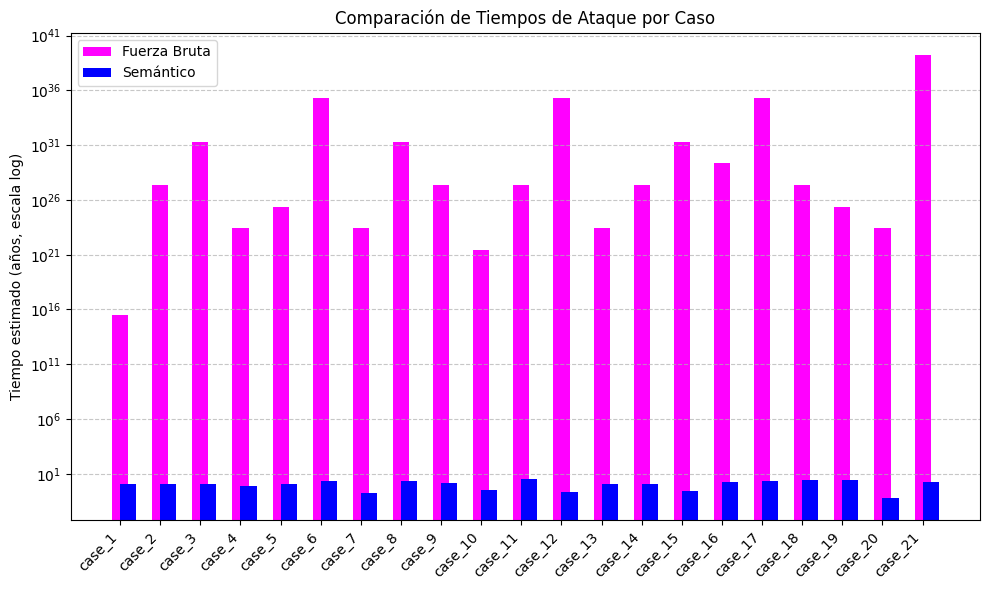

In [102]:
import matplotlib.pyplot as plt
import numpy as np

casos = tablaComparativa["Caso"]
brute_times = tablaComparativa["Fuerza Bruta (años)"]
semantic_times = tablaComparativa["Semántico (años)"]

x = range(len(casos))

plt.figure(figsize=(10, 6))
plt.bar(x, brute_times, width=0.4, label='Fuerza Bruta', align='center', color='fuchsia')
plt.bar(x, semantic_times, width=0.4, label='Semántico', align='edge', color='blue')

plt.yscale("log")
plt.xticks(x, casos, rotation=45, ha="right")
plt.ylabel("Tiempo estimado (años, escala log)")
plt.title("Comparación de Tiempos de Ataque por Caso")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7, which="both")
plt.tight_layout()
plt.show()



### Análisis de Resultados


En la sección anterior se presentaron los resultados obtenidos al comparar el tiempo estimado para romper contraseñas usando un ataque tradicional de fuerza bruta versus un ataque semántico basado en diccionarios construidos con relaciones lingüísticas.

#### Comparación de tiempos

Los resultados evidencian una diferencia drástica en la eficiencia entre ambos enfoques:

* El ataque de fuerza bruta genera tiempos de recuperación que superan fácilmente los 10²⁰ años en muchos casos, especialmente en contraseñas largas o con caracteres especiales.

* Por el contrario, el método semántico logra reducir estos tiempos a escalas prácticas, generalmente entre 10 y 100 años, e incluso menos en contraseñas altamente predictibles.

* En algunos casos, el tiempo estimado para el ataque semántico fue más de 10³⁶ veces más rápido que el de fuerza bruta.

#### Casos exitosos del ataque semántico

El enfoque semántico mostró especial eficacia en contraseñas compuestas por:

* Palabras comunes del español

* Nombres propios

* Expresiones culturales o religiosas

* Combinaciones simples con números (ej. Gabriel1950)

Esto valida que muchos usuarios tienden a elegir contraseñas predecibles, lo cual puede ser explotado semánticamente.

#### Casos Límite


Sin embargo, en los casos case_21 y similares, donde las contraseñas eran totalmente aleatorias y sin estructura semántica, el ataque semántico algo ineficaz. Sin embargo, este método puede reducir considerablemente el espacio de búsqueda cuando hay alguna base lingüística.

### Conclusión General

El uso de embeddings semánticos y diccionarios contextuales permite:

* Disminuir radicalmente el tiempo de ataque en escenarios realistas.

* Priorizar contraseñas más probables según el lenguaje natural.

* Aumentar la eficiencia computacional sin recorrer todo el espacio de búsqueda.

Este análisis enfatiza la importancia de contraseñas aleatorias y sin sentido lingüístico para evitar ataques de este tipo, y plantea un llamado a fortalecer las políticas de generación de claves en sistemas reales.